In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = r'/content/drive/MyDrive/Keypoints/tennis_court_det_dataset(1).zip'

extract_path = r'/content/drive/MyDrive/Keypoints'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
import torch
import json
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class keyDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file,'r') as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
       item = self.data[idx]
       img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
       h,w = img.shape[:2]

       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       img = self.transforms(img)
       kps = np.array(item['kps']).flatten()
       kps = kps.astype(np.float32)

       kps[::2] *= 224.0 / w # x coordinates
       kps[1::2] *= 224.0 / h # y coordinates

       return img, kps

In [7]:
train_dataset = keyDataset('/content/drive/MyDrive/Keypoints/data/images','/content/drive/MyDrive/Keypoints/data/data_train.json')
valid_dataset = keyDataset('/content/drive/MyDrive/Keypoints/data/images','/content/drive/MyDrive/Keypoints/data/data_val.json')

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
Valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle = True)

In [8]:
model = models.resnet50(pretrained = True)
model.fc = torch.nn.Linear(model.fc.in_features,14*2) #last layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


In [9]:
model = model.to(device)

In [10]:
criterian = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)

In [13]:
import torch
from torch.utils.data import DataLoader

# Load your trained model
model = models.resnet50()
model.fc = torch.nn.Linear(model.fc.in_features, 14*2)  # Match your architecture
model.load_state_dict(torch.load('/content/drive/MyDrive/Keypoints/model_keypoints.pth'))  # Your saved model
model = model.to(device)
model.eval()

# PCK Metric (Percentage of Correct Keypoints within threshold pixels)
def calculate_accuracy(loader, threshold=3):
    total_correct = 0
    total_keypoints = 0

    with torch.no_grad():
        for imgs, kps in loader:
            imgs, kps = imgs.to(device), kps.to(device)
            preds = model(imgs)

            # Reshape to [batch, 14 keypoints, 2 coordinates]
            preds = preds.view(-1, 14, 2)
            kps = kps.view(-1, 14, 2)

            # Calculate distances (in pixels)
            distances = torch.sqrt(((preds - kps)**2).sum(dim=-1))  # Euclidean distance

            # Count correct predictions (within threshold)
            correct = (distances < threshold).sum().item()
            total_correct += correct
            total_keypoints += kps.numel() // 2  # Each keypoint has x,y

    accuracy = (total_correct / total_keypoints) * 100
    return accuracy

# Calculate accuracy
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
accuracy = calculate_accuracy(val_loader, threshold=3)  # 5-pixel threshold

print(f"Model Accuracy (PCK@5px): {accuracy:.1f}%")

Model Accuracy (PCK@5px): 96.8%


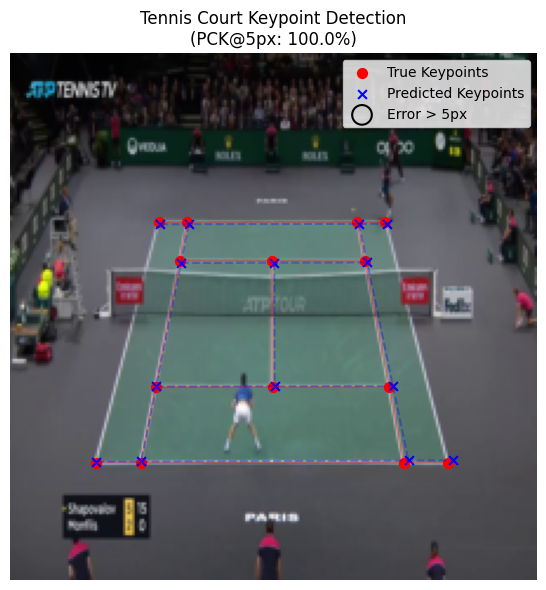

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_sample(model, val_loader, device, threshold=5):
    # Get a sample batch
    img, true_kps = next(iter(val_loader))

    # Move to device and make prediction
    img, true_kps = img[0].to(device), true_kps[0].to(device)
    with torch.no_grad():
        pred_kps = model(img.unsqueeze(0)).squeeze(0).view(14, 2)

    # Convert tensors to numpy arrays safely
    img_np = img.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Unnormalize
    img_np = np.clip(img_np, 0, 1)  # Ensure valid image range

    true_kps_np = true_kps.cpu().view(14, 2).numpy()
    pred_kps_np = pred_kps.cpu().numpy()

    # Calculate distances for error visualization
    distances = np.sqrt(np.sum((true_kps_np - pred_kps_np)**2, axis=1))

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_np)

    # Plot keypoints
    plt.scatter(true_kps_np[:, 0], true_kps_np[:, 1],
                c='red', s=50, label='True Keypoints')
    plt.scatter(pred_kps_np[:, 0], pred_kps_np[:, 1],
                c='blue', marker='x', s=40, label='Predicted Keypoints')

    # Highlight incorrect predictions
    incorrect = distances > threshold
    plt.scatter(pred_kps_np[incorrect, 0], pred_kps_np[incorrect, 1],
                s=200, facecolors='none', edgecolors='black',
                linewidths=1.5, label=f'Error > {threshold}px')

    # Add connecting lines to show court structure (optional)
    for i in range(0, 14, 2):
        plt.plot([true_kps_np[i,0], true_kps_np[i+1,0]],
                 [true_kps_np[i,1], true_kps_np[i+1,1]], 'r-', alpha=0.3)
        plt.plot([pred_kps_np[i,0], pred_kps_np[i+1,0]],
                 [pred_kps_np[i,1], pred_kps_np[i+1,1]], 'b--', alpha=0.3)

    plt.title(f'Tennis Court Keypoint Detection\n(PCK@{threshold}px: {100*(distances < threshold).mean():.1f}%)')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage example
plot_sample(model, val_loader, device, threshold=5)